# Local-Global-Trend(LGT) Example

In [1]:
import pandas as pd
import numpy as np
from uTS.lgt import LGT
from uTS.utils.utils import plot_predicted_data

## Data

In [2]:
DATA_FILE = "./data/iclaims.example.csv"

In [3]:
raw_df = pd.read_csv(DATA_FILE, parse_dates=['week'])

In [4]:
raw_df.dtypes

week              datetime64[ns]
claims                     int64
trend.unemploy           float64
trend.filling            float64
trend.job                float64
dtype: object

### Data Transformation

In [5]:
df=raw_df.copy()
df[['claims', 'trend.unemploy', 'trend.filling', 'trend.job']] = \
    df[['claims', 'trend.unemploy', 'trend.filling', 'trend.job']].apply(np.log, axis=1)
df.head(5)

,week,claims,trend.unemploy,trend.filling,trend.job
0,2010-01-03,13.386595,0.168876,-0.328309,0.113033
1,2010-01-10,13.624218,0.168876,-0.204695,0.164326
2,2010-01-17,13.398741,0.185136,-0.302334,0.113033
3,2010-01-24,13.137549,0.152346,-0.204695,0.102451
4,2010-01-31,13.196760,0.083354,-0.252323,0.070016


### Train / Test Split

In [6]:
test_size=52
train_df=df[:-test_size]

# in uTS we make assertion that test dates need to be between train start/end
test_df=df[-test_size:]

## MAP Fit and Predict

In [7]:
lgt_map=LGT(
    response_col='claims',
    date_col='week',
    seasonality=52,
    seed=8888,
    predict_method='map'
)

In [8]:
lgt_map.fit(df=train_df)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_20dc3d49f4f6bf0cd77f94e9dd3c1508 NOW.


In [9]:
predicted_df = lgt_map.predict(df=test_df)

In [10]:
predicted_df.head(5)

,week,prediction
0,2017-07-02,12.415435
1,2017-07-09,12.532846
2,2017-07-16,12.374070
3,2017-07-23,12.228280
4,2017-07-30,12.180592


/Users/edwinng/work/venv/env3_uTS/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


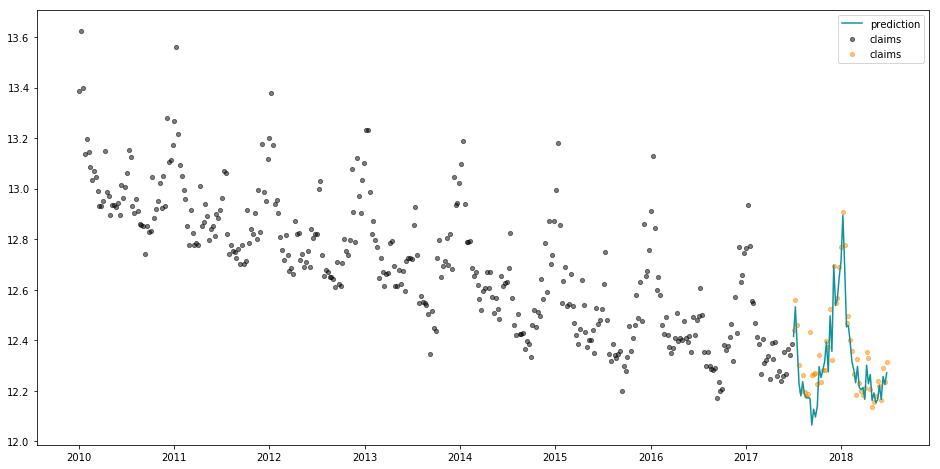

In [11]:
plot_predicted_data(training_actual_df=train_df, predicted_df=predicted_df, 
                    date_col=lgt_map.date_col, actual_col=lgt_map.response_col, pred_col='prediction', 
                    test_actual_df=test_df)

## MCMC Fit and Predict

In [12]:
lgt_mcmc = LGT(
    response_col='claims',
    date_col='week',
    seasonality=52,
    num_warmup=4000, 
    num_sample=500,
    sample_method='mcmc',
    predict_method='full',
    n_bootstrap_draws=500
)

In [13]:
lgt_mcmc.fit(df=train_df)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [14]:
predicted_df = lgt_mcmc.predict(df=test_df)

In [15]:
predicted_df.tail(5)

,week,5,50,95
47,2018-05-27,12.110257,12.235313,12.340791
48,2018-06-03,12.053740,12.174436,12.297840
49,2018-06-10,12.150203,12.265919,12.382535
50,2018-06-17,12.112650,12.235118,12.363945
51,2018-06-24,12.161034,12.281387,12.412502


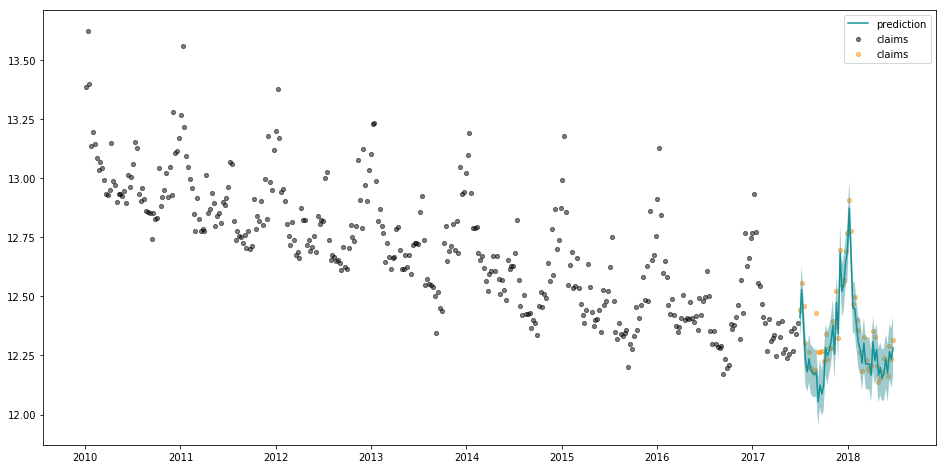

In [16]:
plot_predicted_data(training_actual_df=train_df, predicted_df=predicted_df, 
                    date_col=lgt_mcmc.date_col, actual_col=lgt_mcmc.response_col, pred_col=50, 
                    pred_quantiles_col=[5,95], test_actual_df=test_df)

## Mean Fit and Predict Decomp

In [17]:
lgt_mean=LGT(
    response_col='claims',
    date_col='week',
    seasonality=52,
    seed=8888,
    predict_method='mean'
)

In [ ]:
lgt_mean.fit(df=train_df)

In [ ]:
predicted_df = lgt_mean.predict(df=test_df, decompose=True)

In [ ]:
predicted_df.head(5)

In [ ]:
plot_predicted_data(training_actual_df=train_df, predicted_df=predicted_df, 
                    date_col=lgt_mean.date_col, actual_col=lgt_mean.response_col, pred_col='prediction', 
                    test_actual_df=test_df)

## MAP Fit and Decomp with Regression

In [ ]:
lgt_reg=LGT(
    response_col='claims',
    regressor_col=['trend.unemploy', 'trend.filling'],
    date_col='week',
    seasonality=52,
    seed=8888,
    predict_method='map'
)

In [ ]:
lgt_reg.fit(df=train_df)

In [ ]:
predicted_df = lgt_reg.predict(df=test_df, decompose=True)

In [ ]:
predicted_df.head(5)